<a href="https://colab.research.google.com/github/devadharshini97/Laplacian-Blob-Detector/blob/main/source_code_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time Taken For 10 Convolutions: 0.5835576057434082 sec

Time Taken to obtain Difference of Gaussian Images: 0.6056110858917236 sec

Time Taken to Detect Blobs: 2.374695301055908 sec
Number of Blobs Detected = 35346



<ipython-input-18-a4f34f9635b7>:190: RuntimeWarning: invalid value encountered in arccos
  area = (r1**2 * np.arccos((d**2 + r1**2 - r2**2)/(2 * d * r1)) + r2**2 * np.arccos((d**2 + r2**2 - r1**2)/(2 * d * r2)) -


Time Taken to Perform NMS: 441.9660496711731 sec
Number of Blobs (After NMS) = 827

Time Taken to Execute Entire Progam = 441.96748089790344 sec


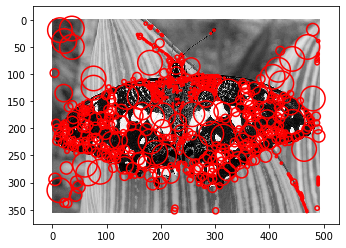

In [ ]:
"""
BLOB DETECTION USING DIFFERENCE OF GAUSSIANS
"""
#Importing Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import time
from google.colab.patches import cv2_imshow

#Time Function to Determine Program Execution Time
tick = time.time()

#Histrogram Equalization Function
def hist_eq(fimg):
	min_px, max_px = np.min(fimg), np.max(fimg)
	equalized_img = (fimg - min_px)/255
	return equalized_img

#Generate Gaussian Kernel and Pad it to Image size for Frequency Domain Convolution 
def gauss_kernel(sigma):

	#Determine Kernal Size from Sigma
	ksize = int(np.round(3 * sigma) * 2 + 1)
	kernel1D = cv2.getGaussianKernel(ksize,sigma)
	g_kernel = np.outer(kernel1D,kernel1D)

	krow, kcol = g_kernel.shape
	kernel_pad = np.zeros((row, col))

	#Kernel Pad Dimensions
	row_lower = (row//2)-(krow//2)
	row_upper = (row//2)+(krow//2)+1

	col_lower = (col//2)-(kcol//2)
	col_upper = (col//2)+(kcol//2)+1

	kernel_pad[row_lower:row_upper, col_lower:col_upper] = g_kernel

	return kernel_pad

#Function to Convert Image into Frequency Domain
def DFT2(f):
	#Initializing Empty Complex Matrix
	f_2DFFT = np.zeros([row, col], dtype=complex)

	#Calculating 1-D FFT of Rows
	for i in range(row):
			f_2DFFT[i] = np.fft.fft(f[i])

	#Calculating 1-D FFT of Columns 
	f_2DFFT = f_2DFFT.T
	for j in range(col):
			f_2DFFT[j] = np.fft.fft(f_2DFFT[j])

	#Obtaining Original Matrix and Shifting Center
	f_2DFFT = f_2DFFT.T
	f_2DFFT = np.fft.fftshift(f_2DFFT)

	return f_2DFFT

#Function to Convert Image into Spatial Domain using DFT
def iDFT2(df):

	conj_f = df.conjugate()
	f_iFFT = DFT2(conj_f)
	f_iFFT = f_iFFT.conjugate()/(row*col)

	return f_iFFT

#Frequency Domain Convolution/Multiplication of Image and Kernel
def convolution_list(scale):
	#List to Store Filtered Image till n octaves
	conv_list = []

	for i in range(0,scale):
		#The Sigma is updated every scale using the formula sigma^i for i iterations
		temp_sigma = np.power(scale_factor,i)

		#Obtain the Gaussian Kernel
		g_kernel = gauss_kernel(temp_sigma)

		#Find Gaussian Kernel Frequency
		freq_kernel = DFT2(g_kernel)

		#Perform Frequency Domain Element Multiplication (Convolution)
		conv = freq_img*freq_kernel

		#Convert the Image into Spatial Domain
		i_conv = np.abs(iDFT2(conv)).real

		#Append the Filtered Image to List
		conv_list.append(i_conv)

	return conv_list

#Function to obtain and store Difference of Gaussians between consecutive sigma Filtered Images
def DoG(img_list):
	dog_list = []
	for i in range(len(img_list)-1):
		dog_list.append(np.abs(img_list[i]-img_list[i+1]))

	return np.array(dog_list)

#Function to detect Features (Blobs) across every Ocatave in DoG Array
def detect_blob(img_list, threshold):
	#List to store Feature Coordinate and Size of Feature
    blob_point_list = []

    #Iterating through dimensions of Filtered images in every Ocatave of DoG
    for i in range(1,row):
        for j in range(1,col):

        	#Generate a 5x5 Window (Faster Iteration) and obtain maximum feature size across every Octave in DoG
            window = img_list[:,i-1:i+4,j-1:j+4]

            #If feature point is maximum than threshold then store feature coordianates and sigma scale size
            if np.max(window) >= threshold:
                sigma_scale,x,y = np.unravel_index(window.argmax(), window.shape)
                blob_point_list.append((i+x-1, j+y-1, scale_factor**sigma_scale))

    return blob_point_list
    
#Function to perform Non-Maximum Supression and Eliminate Redundant Blobs
def NMS(blobs_array, overlap_threshold):
	#Initialize Blob Overlap Threshold Ratio
	blob_ratio = 0

	#Assign Parameters to perform Nearest Neighbor Search
	#Cannot compare every pixel with every other Pixel (Redundancy Error)
	sigma = blobs_array[:, -1].max()
	distance = 2 * sigma * np.sqrt(blobs_array.shape[1] - 1)
	tree = spatial.cKDTree(blobs_array[:, :-1])

	#Obtain Pairs of Nearest Neighbor Feature Coordinates
	pairs = np.array(list(tree.query_pairs(distance)))

	#For Each Pair of Nearest Features
	for (i, j) in pairs:

		#Initialize Feature Coordinates and Radius of Blob (r = sqrt(2)*sigma_scale)
		blob1, blob2 = blobs_array[i], blobs_array[j]
		y1, x1, r1 = blob1[0], blob1[1], blob1[2] * np.sqrt(2)
		y2, x2, r2 = blob2[0], blob2[1], blob2[2] * np.sqrt(2)

		#Calculate Distance between Blob Circle Centers
		d = np.sqrt((x1-x2)**2 + (y1-y2)**2)

		#If No Overlap between 2 Blobs then Pass 
		#(Distance > Sum of Blobs Radii)
		if d > r1 + r2:
		    blob_ratio = 0

		#If One Blob is Inside another, use only the Bigger Blob
		#(Distance < Sum of Blobs Radii)
		elif d <= abs(r1 - r2):
		    blob_ratio = 1

		#If Both Blobs Overlap, Find Area and Ratio of Overlap
		#Reference: https://mathworld.wolfram.com/Circle-CircleIntersection.html
		else:
			area = (r1**2 * np.arccos((d**2 + r1**2 - r2**2)/(2 * d * r1)) + r2**2 * np.arccos((d**2 + r2**2 - r1**2)/(2 * d * r2)) - 
					(0.5 * np.sqrt(np.abs((-d + r2 + r1)*(d + r2 - r1) * (d - r2 + r1) * (d + r2 + r1)))))
		
			blob_ratio = area/(np.pi * (min(r1, r2) ** 2))

		#Eliminate Smaller Blob if Ratio > Threshold
		if blob_ratio > overlap_threshold:
			if r1 > r2:
				blob2[-1] = 0
			else:
				blob1[-1] = 0

	return np.array([b for b in blobs_array if b[-1] > 0])


#Read the Input Image in Grayscale
img = cv2.imread("butterfly.jpg",0)
row, col = img.shape
eq_img = hist_eq(img)
freq_img = DFT2(eq_img)

#Assign Hyperparameters
scale_factor = np.sqrt(2)
blob_detect_threshold = 0.05
nms_threshold = 0.55
octave_number = 10

#Convolve Image with Gaussian Filter
conv_images = convolution_list(octave_number)
tock1 = time.time()
print(f"Time Taken For {octave_number} Convolutions: {tock1-tick} sec\n")

#Obtain Difference of Gaussian of Filtered Images
dog_images = DoG(conv_images)
tock2 = time.time()
print(f"Time Taken to obtain Difference of Gaussian Images: {tock2-tick} sec\n")

#Detect Unique Blobs within Image
blobs = list(set(detect_blob(dog_images, blob_detect_threshold)))
tock3 = time.time()
print(f"Time Taken to Detect Blobs: {tock3-tick} sec")
print(f"Number of Blobs Detected = {len(blobs)}\n")

#Perfrom Non-Maximum Supression and Remove Redundant Blobs
nms_blobs = NMS(np.array(blobs), nms_threshold)
tock4 = time.time()
print(f"Time Taken to Perform NMS: {tock4-tick} sec")
print(f"Number of Blobs (After NMS) = {len(nms_blobs)}\n")
final_tock= time.time()
print(f"Time Taken to Execute Entire Progam = {final_tock-tick} sec")

#Plot Detected Blobs on the Image
fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in nms_blobs:
    y,x,r = blob
    nms_circle = plt.Circle((x, y), r*scale_factor, color='red', linewidth=1.5, fill=False)
    ax.add_patch(nms_circle)
ax.plot()  
plt.show()